In [147]:
import hues
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from torch import nn
from pathlib import Path
from prettytable import PrettyTable
from torch.nn import functional as nn_fun
from scipy.sparse import coo_matrix, csr_matrix, diags, eye

In [148]:
#输出运算资源请况
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


In [149]:
#输出样本路径
path = Path('..\..\pytorch-GNN-1st-main\pytorch-GNN-1st-main\data\第9章28\第9章28\cora')
print(path)

..\..\pytorch-GNN-1st-main\pytorch-GNN-1st-main\data\第9章28\第9章28\cora


In [150]:
#读取论文内容数据，并将其转化为数组
paper_features_label = np.genfromtxt(path / 'cora.content', dtype=np.str_)
print(paper_features_label.shape)
paper_features_label

(2708, 1435)


array([['31336', '0', '0', ..., '0', '0', 'Neural_Networks'],
       ['1061127', '0', '0', ..., '0', '0', 'Rule_Learning'],
       ['1106406', '0', '0', ..., '0', '0', 'Reinforcement_Learning'],
       ...,
       ['1128978', '0', '0', ..., '0', '0', 'Genetic_Algorithms'],
       ['117328', '0', '0', ..., '0', '0', 'Case_Based'],
       ['24043', '0', '0', ..., '0', '0', 'Neural_Networks']],
      dtype='<U22')

In [151]:
#取出数据的第一列：论文的ID
papers = paper_features_label[:, 0].astype(np.int32)
#为论文重新编号，{31336: 0, 1061127: 1,……
paper_id = {k: v for v, k in enumerate(papers)}
paper_id

{31336: 0,
 1061127: 1,
 1106406: 2,
 13195: 3,
 37879: 4,
 1126012: 5,
 1107140: 6,
 1102850: 7,
 31349: 8,
 1106418: 9,
 1123188: 10,
 1128990: 11,
 109323: 12,
 217139: 13,
 31353: 14,
 32083: 15,
 1126029: 16,
 1118017: 17,
 49482: 18,
 753265: 19,
 249858: 20,
 1113739: 21,
 48766: 22,
 646195: 23,
 1126050: 24,
 59626: 25,
 340299: 26,
 354004: 27,
 242637: 28,
 1106492: 29,
 74975: 30,
 1152272: 31,
 100701: 32,
 66982: 33,
 13960: 34,
 13966: 35,
 66990: 36,
 182093: 37,
 182094: 38,
 13972: 39,
 13982: 40,
 16819: 41,
 273152: 42,
 237521: 43,
 1153703: 44,
 32872: 45,
 284025: 46,
 218666: 47,
 16843: 48,
 1153724: 49,
 1153728: 50,
 158098: 51,
 8699: 52,
 1134865: 53,
 28456: 54,
 248425: 55,
 1112319: 56,
 28471: 57,
 175548: 58,
 696345: 59,
 28485: 60,
 1139195: 61,
 35778: 62,
 28491: 63,
 310530: 64,
 1153784: 65,
 1481: 66,
 1153786: 67,
 13212: 68,
 1111614: 69,
 5055: 70,
 4329: 71,
 330148: 72,
 1105062: 73,
 4330: 74,
 5062: 75,
 4335: 76,
 158812: 77,
 40124: 78,

In [152]:
#将数据中间部分的字标签取出，转化成(稀疏)矩阵
features = csr_matrix(paper_features_label[:, 1:-1], dtype=np.float32)
print(np.shape(features))
# 将稀疏矩阵转化为稠密矩阵
features.todense()

(2708, 1433)


matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [153]:
#将最后一项的论文分类属性取出，并转化为分类索引
labels = paper_features_label[:, -1]
lbl2idx = {k: v for v, k in enumerate(sorted(np.unique(labels)))}
labels = [lbl2idx[e] for e in labels]
print(lbl2idx, labels[:5])

{'Case_Based': 0, 'Genetic_Algorithms': 1, 'Neural_Networks': 2, 'Probabilistic_Methods': 3, 'Reinforcement_Learning': 4, 'Rule_Learning': 5, 'Theory': 6} [2, 5, 4, 4, 3]


In [154]:
#读取论文关系数据，并将其转化为数组
edges = np.genfromtxt(path / 'cora.cites', dtype=np.int32)
print(np.shape(edges))
edges

(5429, 2)


array([[     35,    1033],
       [     35,  103482],
       [     35,  103515],
       ...,
       [ 853118, 1140289],
       [ 853155,  853118],
       [ 954315, 1155073]])

In [155]:
#转化为新编号节点间的关系
edges = np.asarray([paper_id[e] for e in edges.flatten()], np.int32).reshape(edges.shape)
print(edges.shape)
edges

(5429, 2)


array([[ 163,  402],
       [ 163,  659],
       [ 163, 1696],
       ...,
       [1887, 2258],
       [1902, 1887],
       [ 837, 1686]])

In [156]:
# 计算邻接矩阵(Adjacency matrix), 行列都为论文个数.
adj = coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                 shape=(len(labels), len(labels)), dtype=np.float32)

adj.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [157]:
# 有向图邻接矩阵转化为无向图对称矩阵
adj_long = adj.multiply(adj.T < adj)
adj = adj_long + adj_long.T

In [158]:
def normalize(mx):  #定义函数，对矩阵数据进行归一化
    '''Row-normalize sparse matrix'''
    rowsum = np.array(mx.sum(1))  #每一篇论文的字数
    r_inv = (rowsum ** -1).flatten()  #取总字数的倒数
    r_inv[np.isinf(r_inv)] = 0.  #将Nan值设为0(防止某一行全为0, 即对应的rowsum为0, r_inv就为)
    r_mat_inv = diags(r_inv)  #将总字数的倒数做成对角矩阵
    mx = r_mat_inv.dot(mx)  #左乘一个矩阵，相当于每个元素除以总数
    return mx


#对 features矩阵进行归一化（每行的总和为1）
features = normalize(features)

# 对邻接矩阵对角线添加1，将其变为自循环图。同时再对其进行归一化
adj = normalize(adj + eye(adj.shape[0]))

In [159]:
# Data as tensors
adj = torch.FloatTensor(adj.todense())  #节点间的关系
features = torch.FloatTensor(features.todense())  #节点自身的特征
labels = torch.LongTensor(labels)  #每个节点的分类标签

In [160]:
#划分数据集
n_train = 200
n_val = 300
n_test = len(features) - n_train - n_val
np.random.seed(34)
idxs = np.random.permutation(len(features))  #将原有索引打乱顺序
n_test

2208

In [161]:
#计算每个数据集的索引
idx_train = torch.LongTensor(idxs[:n_train])
idx_val = torch.LongTensor(idxs[n_train:n_train + n_val])
idx_test = torch.LongTensor(idxs[n_train + n_val:])

In [162]:
#分配运算资源，转到GPU上
adj = adj.to(device)
features = features.to(device)
labels = labels.to(device)
idx_train = idx_train.to(device)
idx_val = idx_val.to(device)
idx_test = idx_test.to(device)

In [163]:
class GraphConvolutionLayer(nn.Module):
    """
    图卷积类——单层图卷积类
    """

    def __init__(self, f_in: int, f_out: int, use_bias: bool = True, activation=None):
        """
        类对象初始化函数
        :param f_in: 输入样本特征数量
        :param f_out: 输出样本特征数量
        :param use_bias: 是否使用偏置
        :param activation: 激活函数
        """
        super().__init__()
        self.f_in = f_in
        self.f_out = f_out
        self.use_bias = use_bias

        # 权重与偏置参数的定义与初始化
        self.weight = nn.Parameter(torch.FloatTensor(f_in, f_out))
        self.bias = nn.Parameter(torch.FloatTensor(f_out)) if use_bias else None

        # 定义激活函数(默认为Mish激活函数)
        self.activation = (lambda x: x * (nn_fun.tanh(nn_fun.softplus(x)))) if activation else activation

        # 学习参数初始化
        self.initialize_weights()

    def initialize_weights(self):
        """
        参数初始化
        """
        # 初始化权重参数
        if self.activation:  # 如果使用激活函数
            nn.init.xavier_uniform_(self.weight)
        else:  # 如果不使用激活函数
            nn.init.kaiming_uniform_(self.weight, nonlinearity='leaky_relu')

        # 初始化偏置参数
        if self.use_bias:  # 偏置项初始化
            nn.init.zeros_(self.bias)

    def forward(self, f_mat, adj_mat) -> torch.tensor:
        """
        前向传播函数
        :param f_mat: 输入特征矩阵，形状：n×feature_in
        :param adj_mat: 样本关系邻接矩阵，形状：n×n, support
        :return: 计算过程参考P285图9-14
        """
        support = torch.mm(f_mat,
                           self.weight)  # input: n×feature_in, self.weight: feature_in×feature_out, support: n×feature_out

        # GCN与CNN唯一不同的地方——每一层都需要与邻接矩阵相乘
        output = torch.mm(adj_mat, support)  # adj: n×n, support: n×feature_out, output: n×feature_out,

        if self.use_bias:  # 如果有偏置项，则将输出进行与偏置进行广播运算
            output.add_(self.bias)

        if self.activation:  # 如果存在激活函数，则将输出传入激活函数
            output = self.activation(output)
        return output

In [164]:
class GCN(nn.Module):
    """
    图卷积类——多层图卷积类
    """

    def __init__(self, f_in: int, n_classes: int, hidden: list, dropout_p: float = 0.5):
        """
        类对象初始化函数
        :param f_in: 输入样本特征数量
        :param n_classes: 卷积结束后，最后一层分类的数量
        :param hidden: 中间隐藏层输出特征f_out数量
        :param dropout_p: dropout参数
        """
        super().__init__()
        # 循环创建单层图神经网络层
        self.layers = nn.Sequential()
        for i, (f_in, f_out) in enumerate(zip([f_in] + hidden[:-1], hidden)):
            self.layers.add_module(f'GCN Layer-{i}', GraphConvolutionLayer(f_in, f_out))

        # Dropout层
        self.layers.add_module(f'Dropout Layer', nn.Dropout(dropout_p))
        # 最后输出层
        self.layers.add_module(f'Output Layer', GraphConvolutionLayer(hidden[-1], n_classes))

    def forward(self, f_mat, adj_mat):
        """
        前向传播函数
        :param f_mat: 输入特征矩阵，形状：n×feature_in
        :param adj_mat: 样本关系邻接矩阵，形状：n×n, support
        :return: 计算过程参考P285图9-14
        """
        for layer in self.layers:
            f_mat = layer(f_mat) if type(layer) == nn.Dropout else layer(f_mat, adj_mat)  # Dropout层只需要传入x

        return f_mat

In [165]:
n_labels = labels.max().item() + 1  #分类个数 7
n_features = features.shape[1]  #节点个数 1433
print(n_labels, n_features)

7 1433


In [166]:
model = GCN(n_features, n_labels, hidden=[16, 32, 16]).to(device)

# 测试图神经网络
demo_features, demo_adj = torch.ones_like(features).to(device), torch.ones_like(adj).to(device)

# 创建一个 PrettyTable 对象
table = PrettyTable()
table.field_names = ['Index', "Layer Name", "Input Shape", "Output Shape"]  #  设置表头

for i, layer in enumerate(model.layers):
    input_shape = demo_features.shape
    demo_features = layer(demo_features) if type(layer) == nn.Dropout else layer(demo_features, demo_adj)
    table.add_row([i, layer.__class__.__name__, input_shape, demo_features.shape])

# 打印表格
print(table)

+-------+-----------------------+--------------------------+------------------------+
| Index |       Layer Name      |       Input Shape        |      Output Shape      |
+-------+-----------------------+--------------------------+------------------------+
|   0   | GraphConvolutionLayer | torch.Size([2708, 1433]) | torch.Size([2708, 16]) |
|   1   | GraphConvolutionLayer |  torch.Size([2708, 16])  | torch.Size([2708, 32]) |
|   2   | GraphConvolutionLayer |  torch.Size([2708, 32])  | torch.Size([2708, 16]) |
|   3   |        Dropout        |  torch.Size([2708, 16])  | torch.Size([2708, 16]) |
|   4   | GraphConvolutionLayer |  torch.Size([2708, 16])  | torch.Size([2708, 7])  |
+-------+-----------------------+--------------------------+------------------------+


In [167]:
# 导入Ranger优化器
from ranger import *

# 创建一个多层GCN网络并将其转移到GPU上
model = GCN(n_features, n_labels, hidden=[16, 32, 16]).to(device)

# 创建优化器
optimizer = Ranger(model.parameters())

# 计算准确度函数：返回本轮计算所有预测结果的平均准确度
get_acc = lambda output, y: (output.argmax(1) == y).type(
    torch.float32).mean().item()  # output.argmax(1)与y都是一个长度为2708的一维张量.


def train():
    """
    训练函数
    :return: 返回损失与精确度
    """
    model.train()  # 告诉模型：即将开始训练
    optimizer.zero_grad()  # 梯度归零
    output = model(features, adj)  # 训练并返回结果
    loss = nn_fun.cross_entropy(output[idx_train], labels[idx_train])  # 计算交叉熵损失函数
    acc = get_acc(output[idx_train], labels[idx_train])  # 计算精准度
    loss.backward()  # 损失反向传播
    optimizer.step()  # 优化器执行
    return loss.item(), acc  # 返回训练损失和精确度


def evaluate(idx):
    """
    测试函数
    :param idx: 需要进行预测的数据行indices
    :return: 返回损失与精确度
    """
    model.eval()  # 告诉模型：开启测试模型（不需要使用Dropout层）
    output = model(features, adj)
    loss = nn_fun.cross_entropy(output[idx], labels[idx]).item()  # 计算交叉熵损失
    return loss, get_acc(output[idx], labels[idx])

In [168]:
#训练模型
epochs = 1000
print_steps = 50
train_loss, train_acc = [], []
val_loss, val_acc = [], []

for i in range(epochs):
    tl, ta = train()
    train_loss.append(tl), train_acc.append(ta)
    if (i + 1) % print_steps == 0 or i == 0:
        # tl, ta = evaluate(idx_train)
        vl, va = evaluate(idx_val)
        val_loss.append(vl), val_acc.append(va)

        hues.log(f'[{i + 1:4d}/{epochs}]: train_loss={tl:.4f}, train_acc={ta:.4f}' +
                 f', val_loss={vl:.4f}, val_acc={va:.4f}')
#输出最终结果
final_train, final_val, final_test = evaluate(idx_train), evaluate(idx_val), evaluate(idx_test)
hues.success(f'Train     : loss={final_train[0]:.4f}, accuracy={final_train[1]:.4f}')
hues.success(f'Test      : loss={final_test[0]:.4f}, accuracy={final_test[1]:.4f}')
hues.success(f'Validation: loss={final_val[0]:.4f}, accuracy={final_val[1]:.4f}')

15:18:42 - [   1/1000]: train_loss=1.9640, train_acc=0.1350, val_loss=1.9567, val_acc=0.1733
15:18:42 - [  50/1000]: train_loss=1.9328, train_acc=0.1400, val_loss=1.9327, val_acc=0.2233
15:18:42 - [ 100/1000]: train_loss=1.9045, train_acc=0.2100, val_loss=1.8893, val_acc=0.2967
15:18:42 - [ 150/1000]: train_loss=1.8189, train_acc=0.3350, val_loss=1.8473, val_acc=0.4133
15:18:42 - [ 200/1000]: train_loss=1.7749, train_acc=0.3950, val_loss=1.7984, val_acc=0.4400
15:18:42 - [ 250/1000]: train_loss=1.6985, train_acc=0.4050, val_loss=1.7404, val_acc=0.4600
15:18:42 - [ 300/1000]: train_loss=1.6474, train_acc=0.4250, val_loss=1.6801, val_acc=0.4800
15:18:42 - [ 350/1000]: train_loss=1.5227, train_acc=0.5300, val_loss=1.5979, val_acc=0.5100
15:18:42 - [ 400/1000]: train_loss=1.4093, train_acc=0.6000, val_loss=1.4908, val_acc=0.5533
15:18:42 - [ 450/1000]: train_loss=1.2526, train_acc=0.6900, val_loss=1.3892, val_acc=0.6400
15:18:42 - [ 500/1000]: train_loss=1.0564, train_acc=0.7450, val_loss=

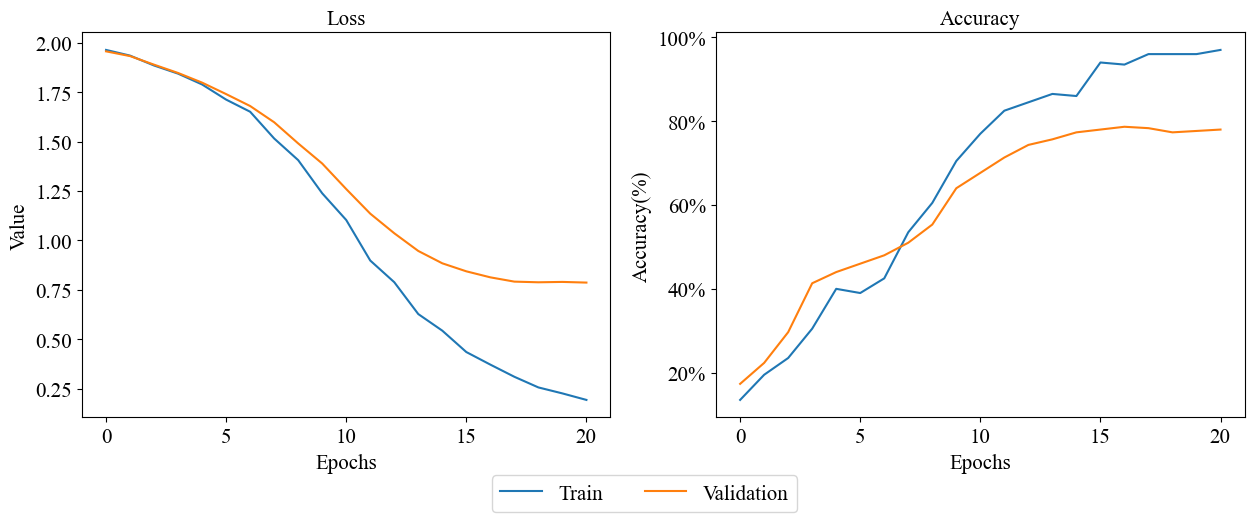

In [169]:
#可视化训练过程
plt.rcParams.update({
    'font.size': 15,
    'font.family': ['Times New Roman', 'SimSun']
})

fig, axes = plt.subplots(1, 2, figsize=(15, 5))
ax = axes[0]
axes[0].plot(train_loss[::print_steps] + [train_loss[-1]], label='Train')
axes[0].plot(val_loss, label='Validation')
axes[1].plot(train_acc[::print_steps] + [train_acc[-1]], label='Train')
axes[1].plot(val_acc, label='Validation')

from matplotlib.ticker import FuncFormatter

plt.gca().yaxis.set_major_formatter(FuncFormatter(lambda temp, _: '%1.0f' % (100 * temp) + '%'))

for ax, t in zip(axes, ['Loss', 'Accuracy']): ax.set_title(t, size=15), ax.set_xlabel('Epochs')

axes[0].set_ylabel('Value')
axes[1].set_ylabel('Accuracy(%)')

lines, texts = fig.axes[-1].get_legend_handles_labels()
fig.legend(lines, texts, ncol=2, loc='lower center', bbox_to_anchor=(0.5, -.1), markerscale=2)

In [174]:
#输出模型预测结果
output = model(features, adj)

samples = 10
idx_sample = idx_test[torch.randperm(len(idx_test))[:samples]]

idx2lbl = {v: k for k, v in lbl2idx.items()}
df = pd.DataFrame({'Real': [idx2lbl[e] for e in labels[idx_sample].tolist()],
                   'Pred': [idx2lbl[e] for e in output[idx_sample].argmax(1).tolist()]})
df

,Real,Pred
0,Case_Based,Case_Based
1,Neural_Networks,Neural_Networks
2,Neural_Networks,Neural_Networks
3,Case_Based,Neural_Networks
4,Probabilistic_Methods,Probabilistic_Methods
5,Theory,Theory
6,Theory,Theory
7,Theory,Probabilistic_Methods
8,Neural_Networks,Neural_Networks
9,Reinforcement_Learning,Reinforcement_Learning
